# LCP Project: analysis of MAGIC04 dataset
First, we import the libraries

In [2]:
# math libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd

# general OS libraries
from time import time
import gzip
import os
import operator
import warnings
from IPython.core.interactiveshell import InteractiveShell

# ML libraries
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.datasets import make_classification
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Then, we import the dataset and we put it into a DataFrame:

In [3]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
#file_name="/home/samu/LaboratoryOfComputationalPhysics_Y7/Project/magic04.data"
file_name= "magic04.dat"
data = pd.DataFrame(pd.read_csv(file_name))
data.columns=['fLength','fWidth','fSize',
        'fConc','fConc1','fAsym',
        'fM3Long','fM3Trans','fAlpha','fDist','category']
data   
#### save data in a DataFrame

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,category
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
...,...,...,...,...,...,...,...,...,...,...,...
19014,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19015,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19016,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19017,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


Here we write some useful functions for the code

## ML functions

In [9]:
# this function divides the dataset in input in parts_to_be_split parts. One of them is returned as test_set
# the other ones are the training_set. Indexes of the chosen data can be accessed (test_indexes, train_indexes)
# (for example in a K-fold)

def split_train_test_set(data,parts_to_be_split):
    indexes = np.arange(0,data.shape[0],1)
    rnd.shuffle(indexes)
    len_test_set = int(len(indexes) / parts_to_be_split)

    test_indexes = indexes[:len_test_set]
    train_indexes = indexes[len_test_set:]

    train_set = data.iloc[train_indexes]
    test_set = data.iloc[test_indexes]
    
    return train_set, test_set

# this function takes col category and returns as Y (target), the other columns are X (labels)
def split_X_Y(data):
    Y = data['category']
    X = data.drop('category',axis=1)

    return X,Y

# this function takes the point that has the lowest distance from FPR=0 and TPR=1 and computes Q for that point values
def get_best_Q(fpr,tpr):
    distances = np.zeros(len(fpr))
    
    for i in range(len(fpr)):
        distances[i] = np.sqrt(fpr[i]**2+(1-tpr[i])**2)
        
    min_dist_idx = np.argmin(distances)
    best_Q = tpr[min_dist_idx] / np.sqrt(fpr[min_dist_idx])
    return best_Q

## Other useful functions
### Cutting functions

In [11]:
# this function finds cut value starting from possible max
def find_max_cut_value(X_train,Y_train,sel_label,min_hadrons):
    new_X = X_train[X_train.columns[sel_label]]
    new_data = np.vstack((new_X,Y_train))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    
    #new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    
    # setup vars, cut value is  set to max of the label, so that in worst scenario all points are true hadrons
    true_hadrons = 0
    max_cut_value = new_data_sorted[0,0]
    
    for i in range(new_data_sorted.shape[1]):
        if new_data_sorted[1,i] == -1:
            true_hadrons += 1
        if true_hadrons == min_hadrons:
            max_cut_value = new_data_sorted[0,i]
            
    return max_cut_value

# this functions returns the number of true positive and false positive points on test set
def find_tp_fp(X_test,Y_test,sel_label,cut_value):
    new_X = X_test[X_test.columns[sel_label]]
    new_data = np.vstack((new_X,Y_test))
    new_data_sorted = new_data[:, new_data[0].argsort()]
    new_data_sorted_reversed = new_data_sorted[:, ::-1] #reverse!! STARTING FROM MAXX
    fp = 0
    tp = 0
    
    for i in range(new_data_sorted_reversed.shape[1]):
        if new_data_sorted_reversed[0,i] < cut_value:
            if new_data_sorted_reversed[1,i] == 1:
                tp += 1
            if new_data_sorted_reversed[1,i] == -1:
                fp += 1
                
    return tp, fp # true positive, false positive

# Part 1: plot of the features 
the following code plots histograms for each feature, in red there are gammas (signal), in blue hadrons (background). The code saves the histograms in a directory named 'part_1_plots'

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


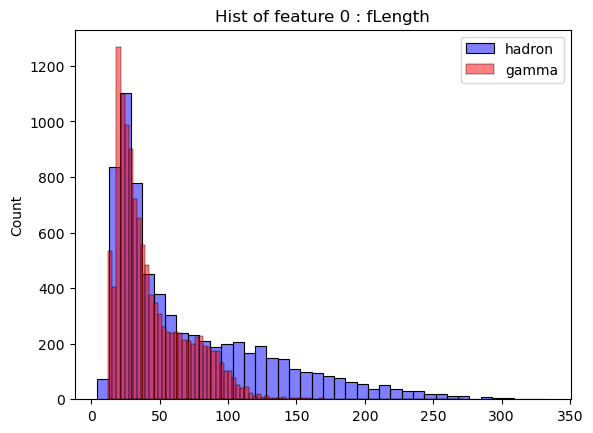

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


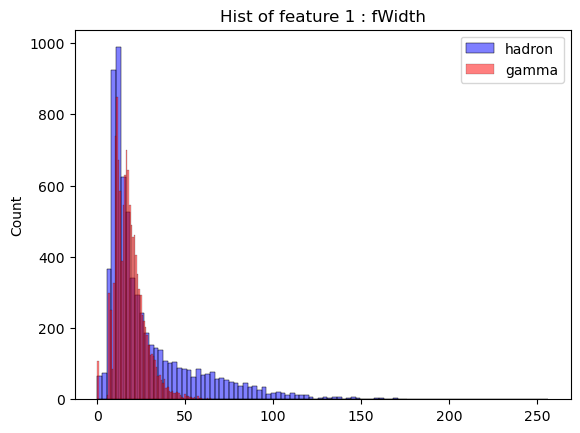

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


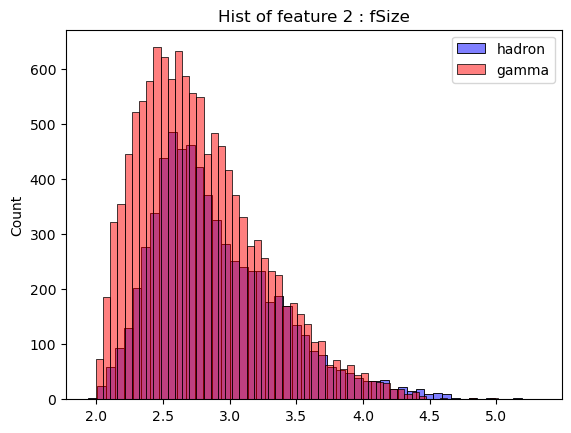

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


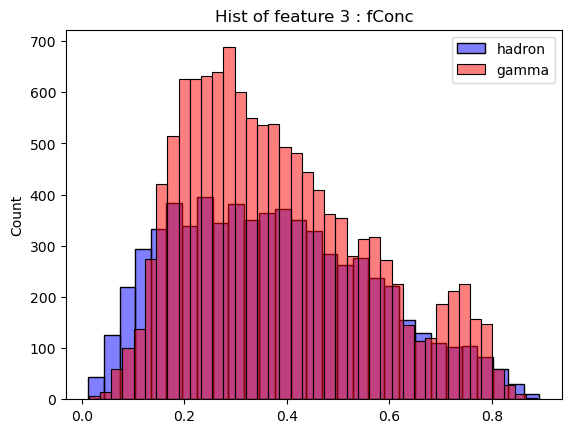

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


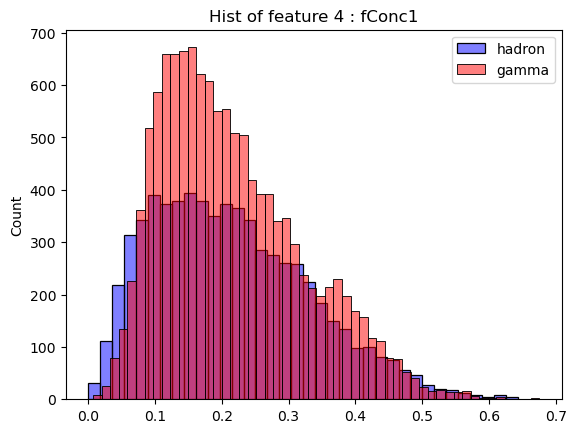

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


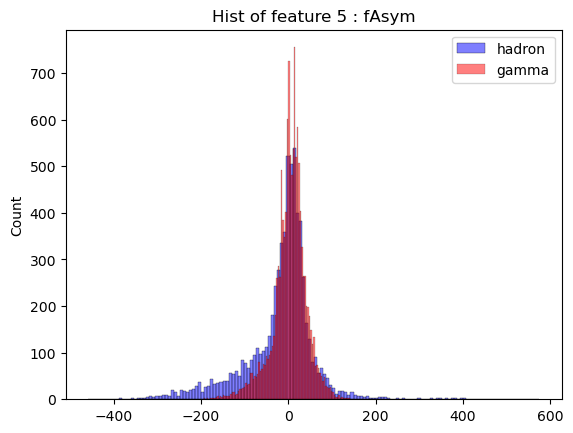

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


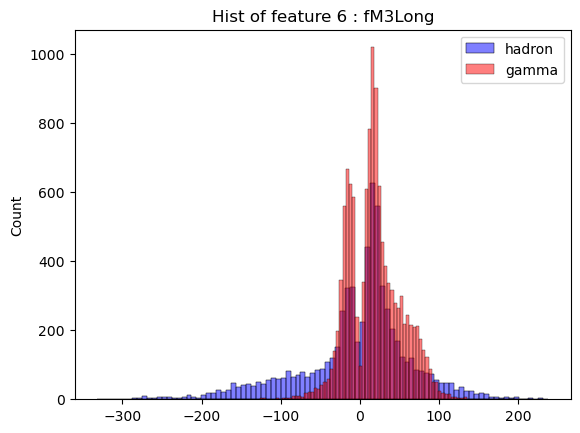

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


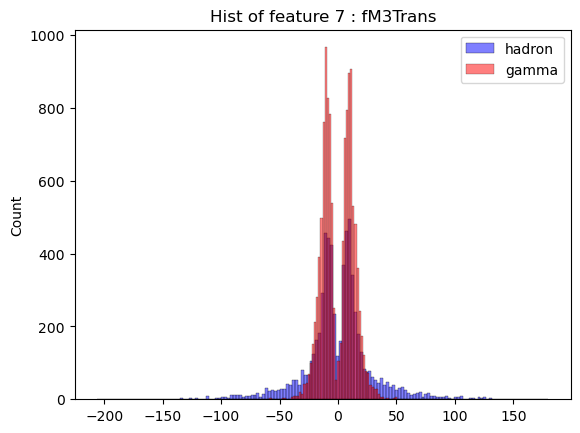

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


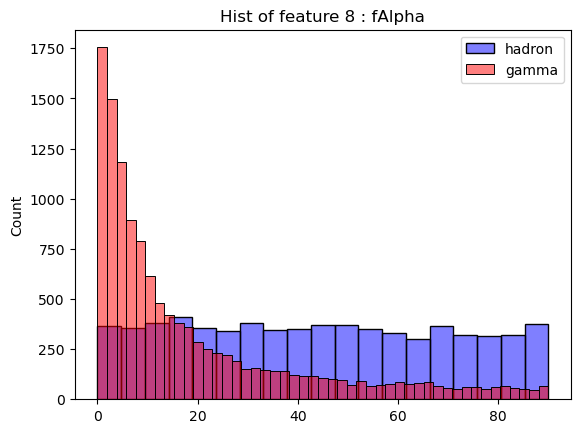

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


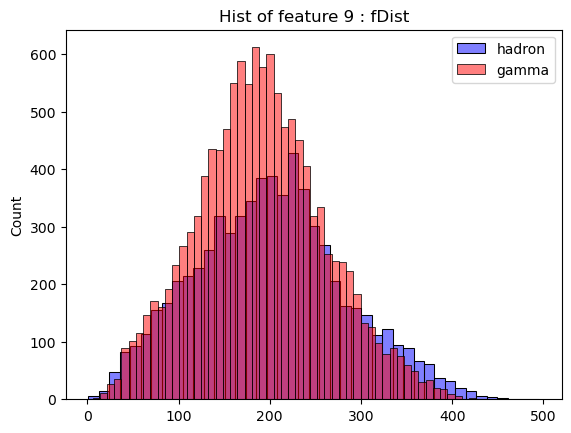

In [15]:
dir_name = 'part_1_plots'

if not os.path.exists(dir_name):
    os.makedirs(dir_name)


# X contains features, Y contains categories
X = data.loc[:,'fLength':'fDist']
Y = data.loc[:,'category']


for i in range(X.shape[1]):
    x_g = []
    x_h = []
    X_temp = X[str(X.columns[i])]
    for j in range(X.shape[0]):
        if (Y[j] == 'g'):
            x_g.append(X_temp[j])
        if (Y[j] == 'h'):
            x_h.append(X_temp[j])
    
    titolo = 'Hist of feature ' + str(i) + ' : ' + X.columns[i]
    img_name = 'hist_'+str(i)+'_'+X.columns[i]+'.png'
    
    ax = sns.histplot(x_h,label='hadron',alpha=0.5,color='blue', edgecolor='black')
    ax2 = sns.histplot(x_g,label='gamma',alpha=0.5,color='red', edgecolor='black')
    t = plt.title(titolo)
    lgnd = plt.legend()
    plt.savefig(os.path.join(dir_name, img_name))  # Save the plot

    plt.show()

# Part 3: Study of features' correlation
In this section we study the correlation between the features. Results will be presented using 2D correlation matrices. We repeat the analysis using all the samples and distinguishing between gamma and background events to spot possible differences. Strongly correlated input features would suggest that we could reduce the dimensionality of the problem disregarding some of them, while still keeping most of the information and variability of the dataset. This will be properly studied performing a Principal Component Analysis in the following part.    
First, we rescale all the features to have zero mean and unitary standard deviation, which will be useful also for the classification algorithms section. 

In [17]:
X_rescaled = X
for i in range(X.shape[1]):
    h = X[str(X.columns[i])]
    avg = np.average(h)
    std = np.std(h)
    h = h - avg
    h = h / std
    X_rescaled[str(X_rescaled.columns[i])] = h
    
#print('media length:',np.average(X_rescaled['fLength']))
#print('dev_std length:',np.std(X_rescaled['fLength']))

This cell computes and prints the correlation matrix for all the data

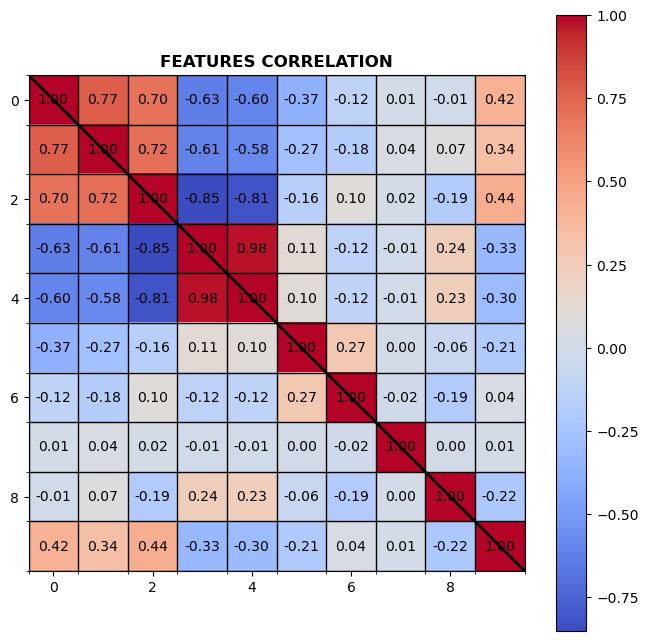

In [19]:
cov = np.zeros((X_rescaled.shape[1],X_rescaled.shape[1]))
for i in range(X_rescaled.shape[1]):
    h = X_rescaled[str(X_rescaled.columns[i])]
    for j in range(X_rescaled.shape[1]):
        v = X_rescaled[str(X_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
            
ticks = np.arange(0,10,1)
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax.set_xticks(np.arange(-0.5, cov.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, cov.shape[0], 1), minor=True)
ax.grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax.text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10) # adds covariance text to each grid
ax.plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
plt.title('FEATURES CORRELATION',fontweight='bold')
plt.show();

It looks like we have good correlation between
- features 0-1
- features 0-2
- features 3-4

And good anti-correlation between
- features 2-3
- features 2-4

The following cell computes the correlation matrix taking apart gammas from hadrons

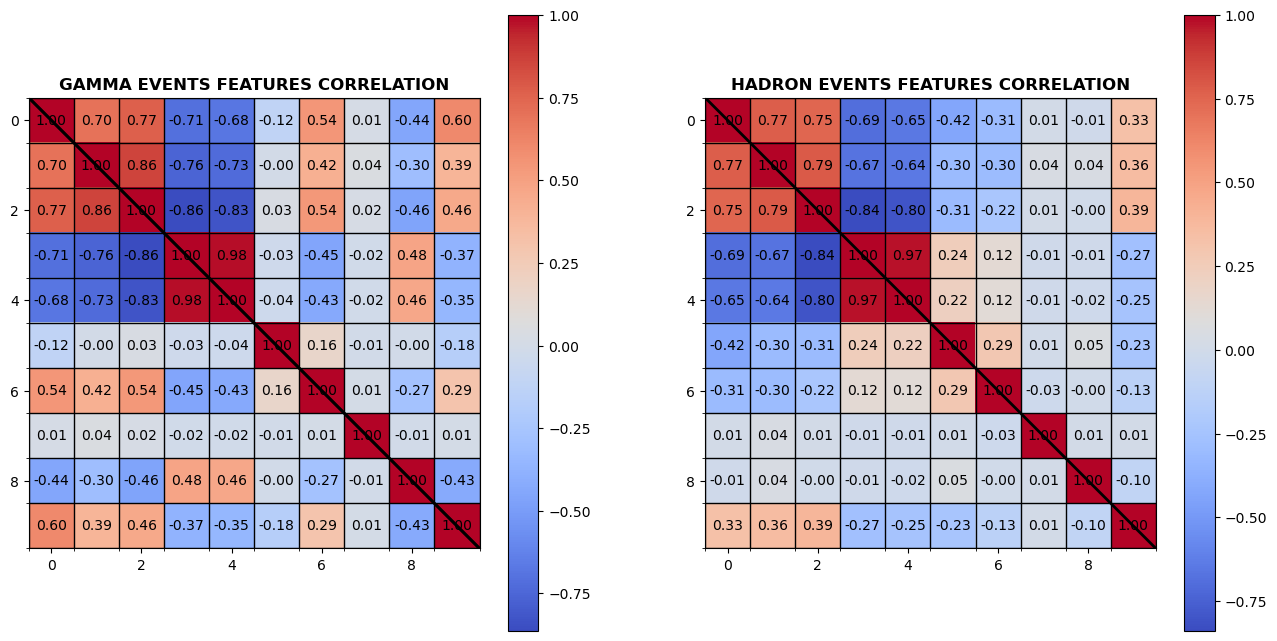

In [23]:
Xg_rescaled = X_rescaled[Y == 'g']
Xh_rescaled = X_rescaled[Y == 'h']

cov = np.zeros((Xg_rescaled.shape[1],Xg_rescaled.shape[1]))
for i in range(Xg_rescaled.shape[1]):
    h = Xg_rescaled[str(Xg_rescaled.columns[i])]
    for j in range(Xg_rescaled.shape[1]):
        v = Xg_rescaled[str(Xg_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xg_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs) # the data for gamma events are not normalized with respsect to themselv   

ticks = np.arange(0,10,1)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cax = ax[0].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[0].set_xticks(np.arange(-0.5, cov.shape[1], 1), minor=True)
ax[0].set_yticks(np.arange(-0.5, cov.shape[0], 1), minor=True)
ax[0].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[0].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[0].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[0].set_title('GAMMA EVENTS FEATURES CORRELATION',fontweight='bold')

cov = np.zeros((Xh_rescaled.shape[1],Xh_rescaled.shape[1]))
for i in range(Xh_rescaled.shape[1]):
    h = Xh_rescaled[str(Xh_rescaled.columns[i])]
    for j in range(Xh_rescaled.shape[1]):
        v = Xh_rescaled[str(Xh_rescaled.columns[j])]
        cov[i,j] = (np.cov(h,v)[0,1])
        
std_devs = np.std(Xh_rescaled, axis=0)
cov = cov / np.outer(std_devs, std_devs)

cax = ax[1].imshow(cov, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cax)
ax[1].set_xticks(np.arange(-0.5, cov.shape[1], 1), minor=True)
ax[1].set_yticks(np.arange(-0.5, cov.shape[0], 1), minor=True)
ax[1].grid(which='minor', color='black', linewidth=1)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        ax[1].text(j, i, f'{cov[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

ax[1].plot([-0.5, cov.shape[1]-0.5], [-0.5, cov.shape[0]-0.5], color='black', linewidth=2, linestyle='-')
ax[1].set_title('HADRON EVENTS FEATURES CORRELATION',fontweight='bold')

plt.show();

# Correlation between features and label (Jonny)

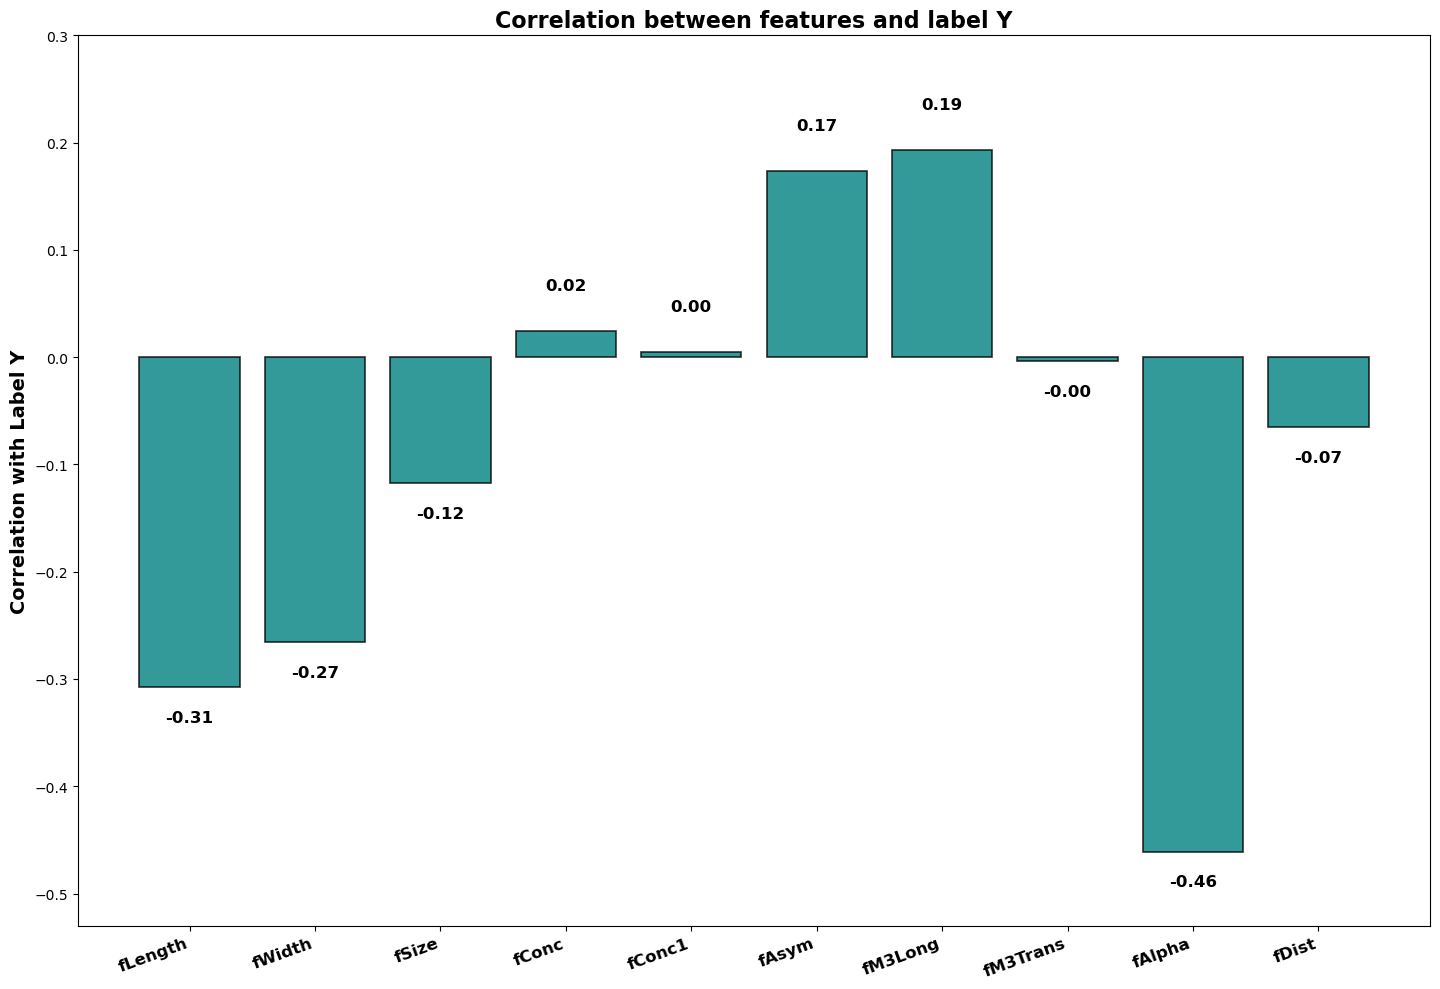

In [99]:
# Calculate the correlation between each feature and the label Y

Y_array = np.where(Y == 'g', 1, -1)
Y_array = np.array(Y_array) 
feature_names = data.columns[:10]

correlations = np.zeros(X_rescaled.shape[1])  
for i in range(X_rescaled.shape[1]):
    feature = X_rescaled.iloc[:, i]  
    correlations[i] = np.corrcoef(feature, Y_array)[0, 1]

# create a bar plot to display the correlations
fig, ax = plt.subplots(figsize=(14.5, 10))

bars = ax.bar(feature_names, correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation with Label Y', fontsize=14, fontweight='bold')
ax.set_ylim(-0.53,0.3)
ax.set_title('Correlation between features and label Y', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(len(feature_names)))
ax.set_xticklabels(feature_names, fontsize=12, fontweight='bold', rotation=20, ha='right')
plt.tight_layout()
plt.show()

The features most strongly correlated with the label Y, and thus most informative for distinguishing between gamma and hadron events, are $Alpha$, $Length$ and $Width$. This is coherent with our observations from the feature histograms, where these features exhibit more distinct distributions between the two classes.

# Part 2: Comparison of the features rescaled

# Part 4: PCA

# Part 5: Machine Learning Analysis
In this section we are going to implement several ML binary classification algorithms to distinguish between gamma and hadron events. We choose as objective for each model to maximize the ROC curve area in the False Positive Rate (FPR) range $[0,0.2]$.

The ROC curve plots the TPR, i.e: the fraction of actual gamma samples correctly identified as gamma, versus the False Positive Rate (FPR), i.e: the fraction of actual hadrons events incorrectly classified as gamma by the model. To do so, it's necessary to estimate a probability for the predicted class, not just to assign the predicted label. We will call $\textbf{\textit{gammaness}}$ the probability returned by each prediction model for a certain event to be a gamma event. Imposing different threshold values on the gammaness for the acceptance of an event as either gamma or hadron, we can obtain the ROC curve. The Area Under the ROC Curve (AUC) represents the overall probability that the model will distinguish between the two classes. However, in our case we are mostly interested in avoiding false positives, we do not really care about loss minimization per se or about the model performance at high FPR. This is the reason why we choose to maximize the partial AUC in a region that is a better indicator of how well the model performs for our specific needs.

## Part 5.1: Perceptron
The following code is about Perceptron algorithm. Scikit learn is going to be used. Also, all the analysis is going to be performed without the feature Alpha

First, we associate +1 label to gammas and -1 label to hadrons. Then we split train and test set (20% of total data)

In [101]:
new_Y = []

# gammas are +1    hadrons are -1

for i in range(len(Y)):
    if (Y.iloc[i] == 'g'):
        new_Y.append(1)
    if(Y.iloc[i] == 'h'):
        new_Y.append(-1)
        
Y_df = pd.DataFrame({'category' : new_Y})
data_rescaled_and_indexed = pd.merge(X_rescaled, Y_df,left_index=True, right_index=True)

# divide dataset in 5 parts, taking 1 as test set ( 20 % )
# remove alpha



parts_to_be_split = 5 
train_set, test_set = split_train_test_set( data_rescaled_and_indexed , parts_to_be_split )
train_alpha = train_set['fAlpha']
train_set = train_set.drop('fAlpha',axis=1)
test_alpha = test_set['fAlpha']
test_set = test_set.drop('fAlpha',axis=1)
X_train, Y_train = split_X_Y(train_set)
X_test, Y_test = split_X_Y(test_set)

print('Train set shapes:',np.shape(X_train),np.shape(Y_train))
print('Test set shapes:',np.shape(X_test),np.shape(Y_test))


Train set shapes: (15216, 9) (15216,)
Test set shapes: (3803, 9) (3803,)


The following cell performs the training. The parameters are set at the beginning and the best model criterion is the one that maximizes ROC area in range [0-0.2]

In [10]:
n_attempts = 10000
limit = 0.2 
best_scores = []
best_f = []
best_t = []
best_score = 0

print('n_iter, score')
for i in range (n_attempts):
    state = abs(np.random.normal(size=1))
    state = int(state[0] * 1000000)
    perceptron = Perceptron(alpha=0.01,penalty='l2',max_iter=50000,tol=1e-4,random_state=state,n_iter_no_change=10)
    
    fitted = perceptron.fit(X_train,Y_train)
    
    decision_values = perceptron.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(Y_test, decision_values)
    
    # here i filter data to compute roc curve area for fpr in range 0 -> 0.8
    fpr_filtered = fpr[fpr <= limit]
    tpr_filtered = tpr[:len(fpr_filtered)]
    
    auc_filtered = np.trapz(tpr_filtered, fpr_filtered)
    auc = roc_auc_score(Y_test, decision_values)
    
    # score is better if filtered is better, though saving all 
    if (auc_filtered > best_score):
        best_score = auc_filtered
        best_scores.append(auc)
        best_f.append(fpr)
        best_t.append(tpr)
        print(i, auc)
    
print("best AUC-ROC Score:")
print(best_scores[len(best_scores)-1])

n_iter, score
0 0.5242643322611676
1 0.5745473388716702
2 0.6323823733759677
8 0.5999206398102674
10 0.6292802500486471
17 0.6806960150936859
42 0.699308145063839
58 0.6698012213295301
72 0.6783694988474167
6349 0.6970017586120445
best AUC-ROC Score:
0.6970017586120445


In the end we take the ROC curve and the best Q value (the one closest to the point (0,1)). We save it in a variable that will be used later as confrontation.

Q value: 1.046792229905368


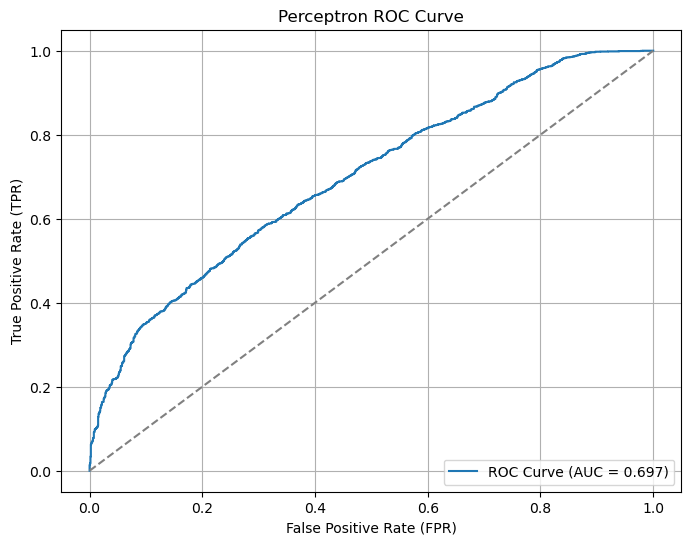

In [11]:
fig = plt.figure(figsize=(8, 6))

fpr_perceptron = best_f[len(best_f)-1] 
tpr_perceptron = best_t[len(best_f)-1]
Q_perceptron = get_best_Q(fpr_perceptron,tpr_perceptron)

print('Q value:',Q_perceptron)
plt.plot(fpr_perceptron, tpr_perceptron, label=f'ROC Curve (AUC = {best_scores[len(best_f)-1]:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title('Perceptron ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

## Part 5.2: SVM
In this part the same dataset is analyzed with soft SVM. Different kernels are tried (linear,poly with deg 3,rbf and sigmoid), as well as different values for parameters such as nu and gamma

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.svm import NuSVC
import time

# list with all possible kernels (poly uses deg = 3 as standard value)
kernels = ['linear','poly','rbf','sigmoid']


# list with all nu values (upper bound on fraction of margin errors)
nus = [ 0.5 , 0.1 , 0.05 , 0.01 ]

# list with all gamma values (by default is 1/(n_features*X.var()) )
gammas = [ 0.1, 0.01, 0.001, 0.0001 ]

best_auc_score = 0

# tolerance for stopping criteria (default is 1e-3) (default max_iter is inf)
tolerance = 1e-6
max_iter = int(1e4)

start_time = time.time()

for kernel_type in kernels:
    for nu in nus:
        for gamma in gammas:
            print(f'training SVM with {kernel_type} kernel...')
            clf = make_pipeline(StandardScaler(), NuSVC(nu=nu,kernel=kernel_type,gamma=gamma,probability=True,tol=tolerance,max_iter=max_iter),verbose=False)

            fitted = clf.fit(X_train, Y_train)
            pred = clf.predict(X_test)
            errors = np.sum(pred != Y_test) / len(Y_test)
            
            pred_prob = clf.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(Y_test, pred_prob)
            
            roc_auc = auc(fpr, tpr)
            
            fpr_filtered = fpr[fpr <= limit]
            tpr_filtered = tpr[:len(fpr_filtered)]
    
            auc_filtered = np.trapz(tpr_filtered, fpr_filtered)
              
            if(auc_filtered > best_auc_score):
                best_auc_score = auc_filtered
                best_tpr = tpr
                best_fpr = fpr
                best_auc = roc_auc
                best_kernel = kernel_type
                best_nu = nu
                best_gamma = gamma
                print(auc_filtered.round(3),best_auc.round(3), kernel_type, nu, gamma)
            print('elapsed time:',time.time()-start_time)
            start_time = time.time()

print('best results are for')
print('kernel:',best_kernel,'nu:',best_nu,'gamma:',best_gamma,'with auc:',best_auc)


training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.001 0.346 linear 0.5 0.1
elapsed time: 24.18678379058838
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.011 0.54 linear 0.5 0.01
elapsed time: 21.61507749557495
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.03 0.616 linear 0.5 0.001
elapsed time: 21.83802342414856
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 21.901559114456177
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 10.726551532745361
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 8.812822818756104
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 7.9511730670928955
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 8.096796751022339
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.148699522018433
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.291765928268433
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.337647914886475
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.33115816116333
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 4.8998863697052
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.808542251586914
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.344388961791992
training SVM with linear kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 4.5541863441467285
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.06 0.785 poly 0.5 0.1
elapsed time: 30.823195934295654
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 30.451175689697266
training SVM with poly kernel...
0.069 0.801 poly 0.5 0.001
elapsed time: 25.44858145713806
training SVM with poly kernel...
elapsed time: 14.867043256759644
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 7.921769857406616
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 7.8955042362213135
training SVM with poly kernel...
elapsed time: 3.9056200981140137
training SVM with poly kernel...
elapsed time: 2.819467306137085
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.1416919231414795
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.120949983596802
training SVM with poly kernel...
elapsed time: 2.1555328369140625
training SVM with poly kernel...
elapsed time: 1.3919200897216797
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 4.737052917480469
training SVM with poly kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 5.0292441844940186
training SVM with poly kernel...
elapsed time: 0.6785123348236084
training SVM with poly kernel...
elapsed time: 0.3078627586364746
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.089 0.844 rbf 0.5 0.1
elapsed time: 39.45743536949158
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 40.28648018836975
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 41.834031105041504
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 43.7575843334198
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 15.051624774932861
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 12.826814651489258
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 11.677820205688477
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 11.942949771881104
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 12.278342723846436
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 9.710479259490967
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 8.704010963439941
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 8.950604677200317
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 10.412477731704712
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 7.228765964508057
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.274868011474609
training SVM with rbf kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.525046110153198
training SVM with sigmoid kernel...
elapsed time: 362.0465404987335
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 52.19610047340393
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 38.85346746444702
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 33.8926899433136
training SVM with sigmoid kernel...
elapsed time: 13.90858006477356
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 13.304558992385864
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 16.84815526008606
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 10.137037515640259
training SVM with sigmoid kernel...
elapsed time: 8.715142488479614
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 6.486491441726685
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 8.856568098068237
training SVM with sigmoid kernel...
elapsed time: 3.134467601776123
training SVM with sigmoid kernel...
elapsed time: 1.7710177898406982
training SVM with sigmoid kernel...
elapsed time: 1.6530852317810059
training SVM with sigmoid kernel...


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


elapsed time: 4.263887405395508
training SVM with sigmoid kernel...
elapsed time: 0.8065440654754639
best results are for
kernel: rbf nu: 0.5 gamma: 0.1 with auc: 0.8443646640367801


The best curve is then plotted and saved

best SVM Q value: 1.5720029472731898


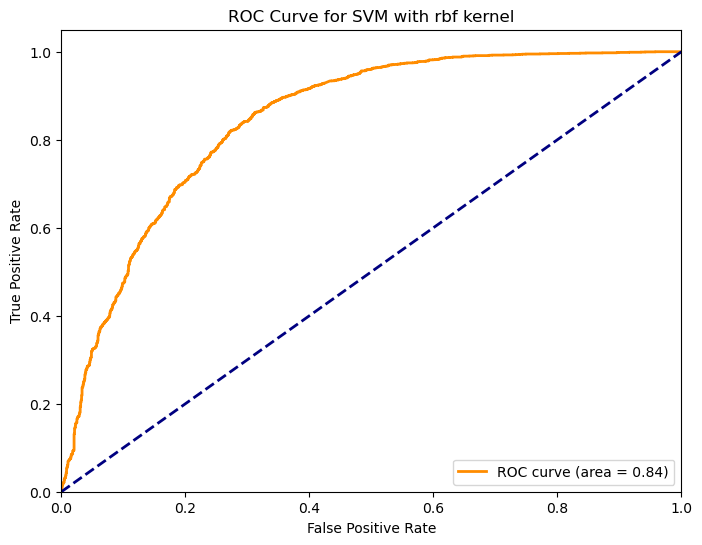

In [13]:
tpr_SVM = best_tpr
fpr_SVM = best_fpr
Q_SVM = get_best_Q(fpr_SVM,tpr_SVM)

print('best SVM Q value:',Q_SVM)
plt.figure(figsize=(8, 6))
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

Let's check how SVM performed in comparison to Perceptron

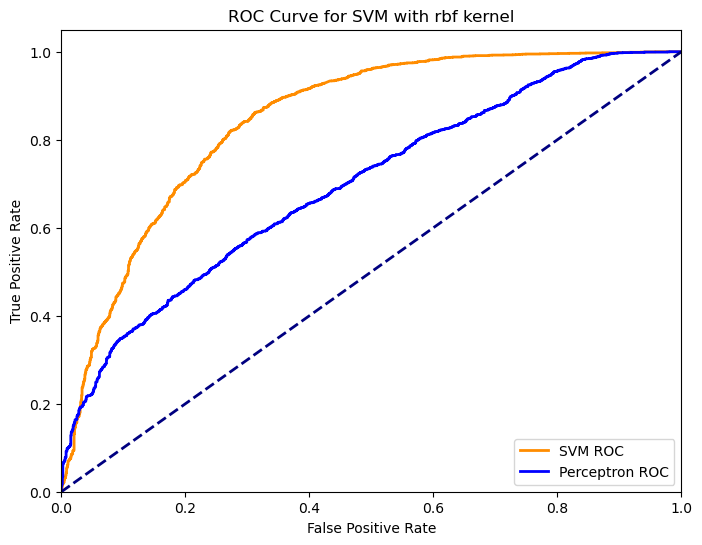

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_SVM, tpr_SVM, color='darkorange', lw=2, label='SVM ROC' % best_auc)
plt.plot(fpr_perceptron, tpr_perceptron, color='blue', lw=2, label='Perceptron ROC' % best_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for SVM with {best_kernel} kernel')
plt.legend(loc='lower right')
plt.show();

## Part 5.3: Random Forest
Here we are going to implement a Random Forest classification algorithm. A Random Forest is composed of different decision tree predictors. For each tree, at each iteration, the data are split into two branches according to a threshold value for one of the features. At each split, the best feature and the best threshold value are chosen by minimizing the entropy function 
𝐻 given by:
$$
\displaystyle H = - \sum_{i=+1,-1} f_i \log_2(f_i)
$$
where $f_i$ is the fraction of points of class $i=+1,-1$ in the training set. The splitting continues until either a maximum depth for the tree is reached, in which case the most frequent class of the branch is assigned to all points, or the points of the branch all belong to the same class (in this case the branch is called a leaf). Different trees are built by randomly drawing data with replacement from the test set, applying the algorithm to each tree. The final label for a point is chosen based on a majority vote of the trees results. 

The hyper-parameters of the model are the **number of trees** and the **maximum depth** of the trees. We are going to implement a K-fold cross validation to choose as best hyper-parameters the ones that maximize the area under the ROC curve of the classifier. To build the ROC curve we need to estimate the probability for the points to belong to a certain class. This can be done because each tree, at the last decision step, assigns a class label based on the majority class of the training samples that reached that final leaf node, but also keeps track of the proportion of the classes in that leaf node. For example, suppose a test point ends up in a leaf node where, out of 100 training samples that ended up there, 80 belonged to class 1 and 20 belonged to class -1. The probability of the point belonging to class 1 would be 0.8, while the probability of it belonging to class -1 would be 0.2.

We will use the class `RandomForestClassifier` from `scikit-learn` to implement and train the Forest and to predict the labels with their probabilities.   


**UTILIZZIAMO COME CRITERIO L'INTERA AREA SOTTO LA CURVA O SOLO FINO AD UNA CERTA SOGLIA DI FALSE POSITIVES??**


In [26]:
num_trees= np.arange(40,300,10)
max_depth= np.arange(10,40,2)
accuracies=[]
roc_areas=[]
best_area=0
best_acc=0
best_model= [] # stores best number of trees and best max depth
partial_aucs = []

start_time = time.time()

max_iter = len(num_trees) * len(max_depth)
iteration = 0

for tree in num_trees:
    for depth in max_depth: 
        forest = RandomForestClassifier(n_estimators=tree,  # number of trees
                                       max_depth= depth, 
                                       max_features=X_train.shape[1],   # number of features for each split (random subset)
                                       bootstrap=True,    # bagging (sampling with replacement)
                                       max_samples=1.0,   # percentage of samples to use for each tree (100% of data)
                                       random_state=10,
                                       n_jobs=-1)
        # train each model, predict labels and probability of each label
        forest.fit(X_train, Y_train)
        Y_pred = forest.predict(X_test)
        y_pred_prob = forest.predict_proba(X_test)[:, 1] # probability for the validation points to belong to class +1 or -1
        # accuracy on validation set
        accuracy = accuracy_score(Y_test, Y_pred)
        accuracies.append(accuracy)
        iteration +=1 
        print(f'elapsed time: {round(time.time()-start_time,2)}s, done {iteration} out of {max_iter}')
        print('Number of trees:',tree,', Maximum depth',depth,':') 
        print('Accuracy:',accuracy)
        # false positive rates and the true positive rates for different threshold values 
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
        # area under the ROC curve on validation set 
        roc_auc = auc(fpr, tpr)
        roc_areas.append(roc_auc)
        '''if(roc_auc>best_area):
            best_area= roc_auc
            best_acc= accuracy
            best_model=[tree,depth]
            '''
        partial_fpr = fpr[fpr <= 0.2]
        if (len(partial_fpr) < 2 ):
            partial_auc = 0
        else:
            partial_tpr = tpr[:len(partial_fpr)]
            partial_auc = auc(partial_fpr, partial_tpr)
        partial_aucs.append(partial_auc)
        if(partial_auc>best_area):
            best_area= partial_auc
            best_total_auc = roc_auc
            best_acc= accuracy
            best_model=[tree,depth]
        print('Area under ROC curve:',roc_auc,'Selected area:',partial_auc,'\n')
        
print('Best number of trees:', best_model[0],'\n')
print('Best maximum depth:', best_model[1],'\n')
print('Area under ROC curve of best model:',best_area)

elapsed time: 0.94s, done 1 out of 390
Number of trees: 40 , Maximum depth 10 :
Accuracy: 0.8154088877202209
Area under ROC curve: 0.857634316053633 Selected area: 0.095624453674328 

elapsed time: 2.01s, done 2 out of 390
Number of trees: 40 , Maximum depth 12 :
Accuracy: 0.8214567446752564
Area under ROC curve: 0.8688632339063818 Selected area: 0.10380950260497843 

elapsed time: 3.17s, done 3 out of 390
Number of trees: 40 , Maximum depth 14 :
Accuracy: 0.8235603470943992
Area under ROC curve: 0.8763089703854123 Selected area: 0.10871720749731147 

elapsed time: 4.54s, done 4 out of 390
Number of trees: 40 , Maximum depth 16 :
Accuracy: 0.8225085458848278
Area under ROC curve: 0.8783222548297782 Selected area: 0.10910607852693825 

elapsed time: 6.06s, done 5 out of 390
Number of trees: 40 , Maximum depth 18 :
Accuracy: 0.8264528004207204
Area under ROC curve: 0.8795812819751111 Selected area: 0.11007673111657532 

elapsed time: 7.65s, done 6 out of 390
Number of trees: 40 , Maximum

elapsed time: 90.28s, done 45 out of 390
Number of trees: 60 , Maximum depth 38 :
Accuracy: 0.8264528004207204
Area under ROC curve: 0.8793362169772247 Selected area: 0.10215184452966737 

elapsed time: 92.14s, done 46 out of 390
Number of trees: 70 , Maximum depth 10 :
Accuracy: 0.8159347883250065
Area under ROC curve: 0.8586559031232293 Selected area: 0.09554118952445495 

elapsed time: 94.07s, done 47 out of 390
Number of trees: 70 , Maximum depth 12 :
Accuracy: 0.8204049434656849
Area under ROC curve: 0.8696839805265589 Selected area: 0.1043958591182784 

elapsed time: 96.7s, done 48 out of 390
Number of trees: 70 , Maximum depth 14 :
Accuracy: 0.8243491980015777
Area under ROC curve: 0.8748154006347595 Selected area: 0.10728600960984189 

elapsed time: 99.6s, done 49 out of 390
Number of trees: 70 , Maximum depth 16 :
Accuracy: 0.8282934525374704
Area under ROC curve: 0.8776796263910145 Selected area: 0.10893055281905573 

elapsed time: 102.99s, done 50 out of 390
Number of trees:

elapsed time: 272.65s, done 89 out of 390
Number of trees: 90 , Maximum depth 36 :
Accuracy: 0.8303970549566132
Area under ROC curve: 0.880353076595088 Selected area: 0.10700800494826948 

elapsed time: 278.28s, done 90 out of 390
Number of trees: 90 , Maximum depth 38 :
Accuracy: 0.8306600052590061
Area under ROC curve: 0.8805226548636939 Selected area: 0.10641676848479377 

elapsed time: 282.05s, done 91 out of 390
Number of trees: 100 , Maximum depth 10 :
Accuracy: 0.8167236392321852
Area under ROC curve: 0.8583698160441783 Selected area: 0.09582697160661989 

elapsed time: 286.26s, done 92 out of 390
Number of trees: 100 , Maximum depth 12 :
Accuracy: 0.8211937943728636
Area under ROC curve: 0.8697609922402694 Selected area: 0.10372074851115773 

elapsed time: 290.47s, done 93 out of 390
Number of trees: 100 , Maximum depth 14 :
Accuracy: 0.8256639495135419
Area under ROC curve: 0.8756000051239478 Selected area: 0.10778971196704082 

elapsed time: 295.43s, done 94 out of 390
Number

elapsed time: 502.31s, done 132 out of 390
Number of trees: 120 , Maximum depth 32 :
Accuracy: 0.8314488561661846
Area under ROC curve: 0.8815209096715122 Selected area: 0.10848464737175033 

elapsed time: 509.14s, done 133 out of 390
Number of trees: 120 , Maximum depth 34 :
Accuracy: 0.8327636076781488
Area under ROC curve: 0.8810664643113993 Selected area: 0.1057010932918375 

elapsed time: 515.61s, done 134 out of 390
Number of trees: 120 , Maximum depth 36 :
Accuracy: 0.8330265579805417
Area under ROC curve: 0.8813456889605157 Selected area: 0.10652793984973415 

elapsed time: 521.75s, done 135 out of 390
Number of trees: 120 , Maximum depth 38 :
Accuracy: 0.830922955561399
Area under ROC curve: 0.8812390925488651 Selected area: 0.10692916325324318 

elapsed time: 525.66s, done 136 out of 390
Number of trees: 130 , Maximum depth 10 :
Accuracy: 0.8169865895345779
Area under ROC curve: 0.8592309747517478 Selected area: 0.09661523605843984 

elapsed time: 530.42s, done 137 out of 390

elapsed time: 804.49s, done 175 out of 390
Number of trees: 150 , Maximum depth 28 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.882781614299718 Selected area: 0.11102633892107962 

elapsed time: 813.82s, done 176 out of 390
Number of trees: 150 , Maximum depth 30 :
Accuracy: 0.8306600052590061
Area under ROC curve: 0.8820883563778814 Selected area: 0.1102360919895008 

elapsed time: 823.19s, done 177 out of 390
Number of trees: 150 , Maximum depth 32 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.8823140540735078 Selected area: 0.10981367130241601 

elapsed time: 832.46s, done 178 out of 390
Number of trees: 150 , Maximum depth 34 :
Accuracy: 0.830922955561399
Area under ROC curve: 0.8820168346081186 Selected area: 0.10958522863481565 

elapsed time: 841.87s, done 179 out of 390
Number of trees: 150 , Maximum depth 36 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.8821185510695935 Selected area: 0.10365974913396132 

elapsed time: 851.39s, done 180 out of 390


elapsed time: 1178.08s, done 218 out of 390
Number of trees: 180 , Maximum depth 24 :
Accuracy: 0.8330265579805417
Area under ROC curve: 0.8820968962906888 Selected area: 0.11035122831395894 

elapsed time: 1187.56s, done 219 out of 390
Number of trees: 180 , Maximum depth 26 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.8828831782627499 Selected area: 0.11025972924816438 

elapsed time: 1198.05s, done 220 out of 390
Number of trees: 180 , Maximum depth 28 :
Accuracy: 0.8322377070733631
Area under ROC curve: 0.8827578245426114 Selected area: 0.11004806140929303 

elapsed time: 1208.87s, done 221 out of 390
Number of trees: 180 , Maximum depth 30 :
Accuracy: 0.8319747567709703
Area under ROC curve: 0.8825499691648148 Selected area: 0.11027833405820928 

elapsed time: 1219.66s, done 222 out of 390
Number of trees: 180 , Maximum depth 32 :
Accuracy: 0.8317118064685775
Area under ROC curve: 0.8826001411525588 Selected area: 0.1102460043882952 

elapsed time: 1230.83s, done 223 out

elapsed time: 1611.3s, done 261 out of 390
Number of trees: 210 , Maximum depth 20 :
Accuracy: 0.8306600052590061
Area under ROC curve: 0.8817284600524229 Selected area: 0.11066842507537998 

elapsed time: 1622.77s, done 262 out of 390
Number of trees: 210 , Maximum depth 22 :
Accuracy: 0.8314488561661846
Area under ROC curve: 0.8821345634061077 Selected area: 0.11068214993524916 

elapsed time: 1634.97s, done 263 out of 390
Number of trees: 210 , Maximum depth 24 :
Accuracy: 0.8319747567709703
Area under ROC curve: 0.8821514907332796 Selected area: 0.11036785064424492 

elapsed time: 1647.45s, done 264 out of 390
Number of trees: 210 , Maximum depth 26 :
Accuracy: 0.8332895082829346
Area under ROC curve: 0.8828802807923332 Selected area: 0.11079637126904934 

elapsed time: 1660.52s, done 265 out of 390
Number of trees: 210 , Maximum depth 28 :
Accuracy: 0.8330265579805417
Area under ROC curve: 0.8828792133032322 Selected area: 0.11078798385468484 

elapsed time: 1673.0s, done 266 out 

elapsed time: 2122.34s, done 304 out of 390
Number of trees: 240 , Maximum depth 16 :
Accuracy: 0.8288193531422561
Area under ROC curve: 0.8796866583992178 Selected area: 0.10985316839915066 

elapsed time: 2134.79s, done 305 out of 390
Number of trees: 240 , Maximum depth 18 :
Accuracy: 0.8303970549566132
Area under ROC curve: 0.8812435150037119 Selected area: 0.10997501465510037 

elapsed time: 2148.39s, done 306 out of 390
Number of trees: 240 , Maximum depth 20 :
Accuracy: 0.830922955561399
Area under ROC curve: 0.8819070357291652 Selected area: 0.11068443741189402 

elapsed time: 2161.26s, done 307 out of 390
Number of trees: 240 , Maximum depth 22 :
Accuracy: 0.832500657375756
Area under ROC curve: 0.88246152006788 Selected area: 0.11026598168432701 

elapsed time: 2174.1s, done 308 out of 390
Number of trees: 240 , Maximum depth 24 :
Accuracy: 0.8319747567709703
Area under ROC curve: 0.8825090995820932 Selected area: 0.11053727641440782 

elapsed time: 2187.15s, done 309 out of 

elapsed time: 2671.76s, done 347 out of 390
Number of trees: 270 , Maximum depth 12 :
Accuracy: 0.8201419931632922
Area under ROC curve: 0.8714175828264794 Selected area: 0.10459654706925443 

elapsed time: 2682.54s, done 348 out of 390
Number of trees: 270 , Maximum depth 14 :
Accuracy: 0.8261898501183277
Area under ROC curve: 0.8775884323221059 Selected area: 0.10887626337335095 

elapsed time: 2694.95s, done 349 out of 390
Number of trees: 270 , Maximum depth 16 :
Accuracy: 0.829082303444649
Area under ROC curve: 0.8803151044827833 Selected area: 0.11039423287488234 

elapsed time: 2707.6s, done 350 out of 390
Number of trees: 270 , Maximum depth 18 :
Accuracy: 0.8296082040494347
Area under ROC curve: 0.881372223689596 Selected area: 0.11065531020928276 

elapsed time: 2721.07s, done 351 out of 390
Number of trees: 270 , Maximum depth 20 :
Accuracy: 0.8301341046542203
Area under ROC curve: 0.8822596121293603 Selected area: 0.1103518383077309 

elapsed time: 2734.06s, done 352 out of

elapsed time: 3228.56s, done 390 out of 390
Number of trees: 290 , Maximum depth 38 :
Accuracy: 0.8332895082829346
Area under ROC curve: 0.8839584447842787 Selected area: 0.11133270829304834 

Best number of trees: 290 

Best maximum depth: 28 

Area under ROC curve of best model: 0.11156343843729356


In [27]:
print(best_area)
print(best_total_auc)


0.11156343843729356
0.8839919944417368


Now we train again the best Random Forest found on the whole training set. We calculate its accuracy and $Q$ factor on the test set, and find the relative ROC curve of the classifier.  

In [28]:
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

best_forest = RandomForestClassifier(n_estimators=best_model[0], max_depth= best_model[1], max_features=X_train_np.shape[1],bootstrap=True,max_samples=1.0,random_state=10,n_jobs=-1)

best_forest.fit(X_train_np,Y_train_np)
Y_pred = best_forest.predict(X_test_np)
accuracy = accuracy_score(Y_test_np, Y_pred)
print('Accuracy of best Random Forest:',accuracy)

y_pred_prob = best_forest.predict_proba(X_test_np)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test_np, y_pred_prob)
partial_fpr = fpr[fpr <= 0.2]
partial_tpr = tpr[:len(partial_fpr)]
partial_auc = auc(partial_fpr, partial_tpr)
roc_auc_best = auc(fpr, tpr)
print('Area under ROC curve of the best Random Forest:',best_area)
print('Partial area under ROC curve under 0.2 fpr:',partial_auc)

Accuracy of best Random Forest: 0.8348672100972916
Area under ROC curve of the best Random Forest: 0.11156343843729356
Partial area under ROC curve under 0.2 fpr: 0.11156343843729356


best random forest Q: 1.7961638155528008


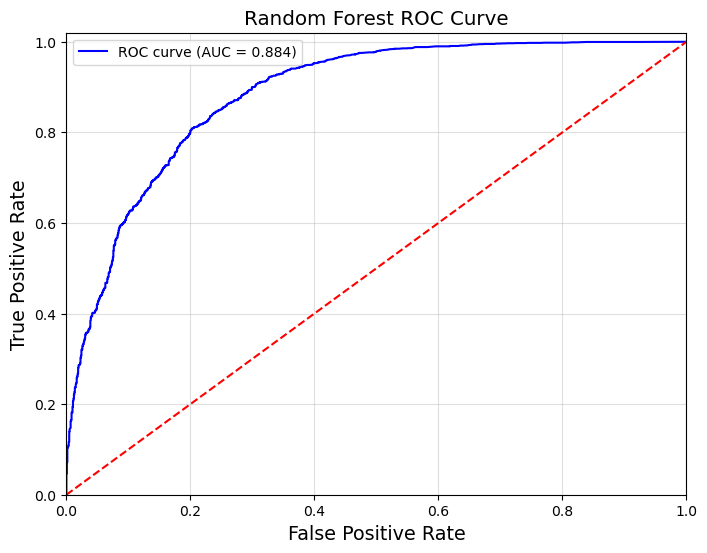

In [29]:
Q_rforest = get_best_Q(fpr,tpr)
fpr_rforest = fpr
tpr_rforest = tpr

print('best random forest Q:',Q_rforest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=1.5, label=f'ROC curve (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Random Forest ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()

## Part 5.4: Neural Network
Now we are going to train a Feed-Forward Fully-Connected Neural Network to classify the samples. Different models are going to be trained in a manual grid search in order to find the combination of hyper-parameters that maximize the partial AUC.

In [30]:
# this function determines the partial area under the curve, up to FPR<=0.2
def partial_auc_at_fpr(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    valid_indices = fpr <= 0.2  # indices where FPR <= 0.2
    partial_fpr = fpr[valid_indices]
    partial_tpr = tpr[valid_indices]
    # check if there are at least 2 points for partial AUC calculation
    if len(partial_fpr) < 2:
        return 0  # return 0 if not enough points to calculate AUC

    partial_auc = auc(partial_fpr, partial_tpr)
    return partial_auc

def full_auc_scorer(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    return auc(fpr, tpr)

# create scoring function (partial AUC) to implement a grid-search
partial_auc_scorer = make_scorer(partial_auc_at_fpr, greater_is_better=True)


In [31]:
# redefine NN cycle
hidden_layer_sizes = [(18,), (36,), (54,), (36,18), (54,18), (54,36), (54,36,18)]
learning_rate_init = [ 0.1 , 0.01 , 0.001 ]

start_time = time.time()

auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict' ) 

parameters = []
fprs = []
tprs = []
aucs = []
partial_aucs = []
hls = []
lrs = []

for size in hidden_layer_sizes:
    for lr in learning_rate_init:
        print(f"Training MLP of size {size} and lr {lr}...")
        lrs.append(lr)
        hls.append(size)
        
        MLP = MLPClassifier(hidden_layer_sizes=size,
                            activation='relu', 
                            max_iter=600, 
                            alpha=1e-4, 
                            solver='sgd', 
                            tol=1e-4, 
                            learning_rate='adaptive',
                            learning_rate_init=lr,
                            verbose=0)
        
        MLP.fit(X_train,Y_train)
        parameters.append(MLP.coefs_)
        
        elapsed_time = time.time() - start_time
        start_time = time.time()
        
        y_pred_proba = MLP.predict_proba(X_test)[:, 1]  

        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        auc_value = auc(fpr, tpr)
        aucs.append(auc_value)
        print("AUC (Test set):", auc_value)
        #print(fpr)
        
        # search for fpr less than 0.2 (if not able fpr is set to zero)
        partial_fpr = fpr[fpr <= 0.2]
        if (len(partial_fpr) < 2 ):
            partial_auc = 0
        else:
            partial_tpr = tpr[:len(partial_fpr)]
            partial_auc = auc(partial_fpr, partial_tpr)
        partial_aucs.append(partial_auc)
        
        print(f"Time needed for training: {elapsed_time:.2f} seconds")
        print("partial AUC:",partial_auc," total AUC:",auc_value,'\n')


Training MLP of size (18,) and lr 0.1...
AUC (Test set): 0.8677625001448734
Time needed for training: 4.44 seconds
partial AUC: 0.10233591015035737  total AUC: 0.8677625001448734 

Training MLP of size (18,) and lr 0.01...
AUC (Test set): 0.8713544484710811
Time needed for training: 10.18 seconds
partial AUC: 0.10430344506182593  total AUC: 0.8713544484710811 

Training MLP of size (18,) and lr 0.001...
AUC (Test set): 0.8480148667682104
Time needed for training: 9.41 seconds
partial AUC: 0.09285386196206936  total AUC: 0.8480148667682104 

Training MLP of size (36,) and lr 0.1...
AUC (Test set): 0.8770408104133255
Time needed for training: 6.75 seconds
partial AUC: 0.10538343903508746  total AUC: 0.8770408104133255 

Training MLP of size (36,) and lr 0.01...
AUC (Test set): 0.8761880391201207
Time needed for training: 11.43 seconds
partial AUC: 0.10871370003312267  total AUC: 0.8761880391201207 

Training MLP of size (36,) and lr 0.001...
AUC (Test set): 0.8560350648819877
Time needed

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.8727064996666384
Time needed for training: 32.17 seconds
partial AUC: 0.10583086946682274  total AUC: 0.8727064996666384 

Training MLP of size (54, 18) and lr 0.1...
AUC (Test set): 0.8735223663366396
Time needed for training: 22.64 seconds
partial AUC: 0.10242008929088833  total AUC: 0.8735223663366396 

Training MLP of size (54, 18) and lr 0.01...
AUC (Test set): 0.879816587072646
Time needed for training: 24.71 seconds
partial AUC: 0.10675562002511955  total AUC: 0.879816587072646 

Training MLP of size (54, 18) and lr 0.001...


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.8725951758032551
Time needed for training: 42.10 seconds
partial AUC: 0.105860149167877  total AUC: 0.8725951758032551 

Training MLP of size (54, 36) and lr 0.1...
AUC (Test set): 0.8632842308680028
Time needed for training: 46.74 seconds
partial AUC: 0.09375634774768951  total AUC: 0.8632842308680028 

Training MLP of size (54, 36) and lr 0.01...
AUC (Test set): 0.8740253062016237
Time needed for training: 34.32 seconds
partial AUC: 0.10130715565394077  total AUC: 0.8740253062016237 

Training MLP of size (54, 36) and lr 0.001...


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.8743059033367269
Time needed for training: 62.42 seconds
partial AUC: 0.10645641807997142  total AUC: 0.8743059033367269 

Training MLP of size (54, 36, 18) and lr 0.1...


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


AUC (Test set): 0.8438110946887231
Time needed for training: 82.02 seconds
partial AUC: 0.08539302813718272  total AUC: 0.8438110946887231 

Training MLP of size (54, 36, 18) and lr 0.01...
AUC (Test set): 0.878391031627567
Time needed for training: 44.73 seconds
partial AUC: 0.10547524309776796  total AUC: 0.878391031627567 

Training MLP of size (54, 36, 18) and lr 0.001...
AUC (Test set): 0.8682919747389379
Time needed for training: 78.89 seconds
partial AUC: 0.10081214570799231  total AUC: 0.8682919747389379 



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Saving the best model's performance and plotting it

In [109]:
best_index_thresh = np.argmax(np.array(partial_aucs))
best_auc_thresh = aucs[best_index_thresh]
best_fpr_thresh = fprs[best_index_thresh]
best_tpr_thresh = tprs[best_index_thresh]
best_model = parameters[best_index_thresh]

fpr_NN = best_fpr_thresh
tpr_NN = best_tpr_thresh
Q_NN = get_best_Q(fpr_NN,tpr_NN)

print('best NN Q value:',Q_NN)

plt.grid()
plt.title('NN best ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(best_fpr_thresh,best_tpr_thresh,label='NN ROC',ms=4,alpha=0.5,c='lightblue')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()


NameError: name 'partial_aucs' is not defined

Now we plot them all

best NN Q value: 1.679
best perceptron Q value: 1.047
best SVM Q value: 1.572
best random forest Q value: 1.796


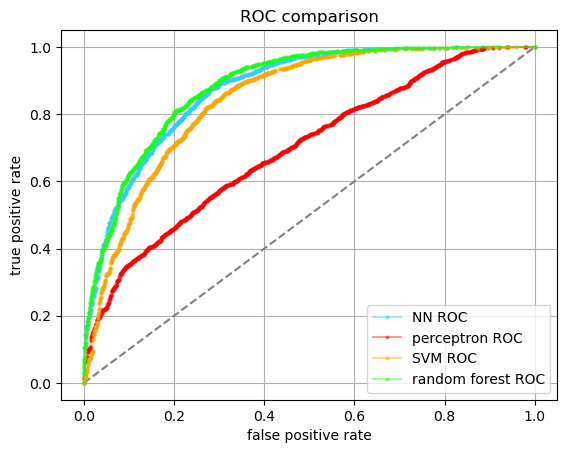

In [33]:
print('best NN Q value:',Q_NN.round(3))
print('best perceptron Q value:',Q_perceptron.round(3))
print('best SVM Q value:',Q_SVM.round(3))
print('best random forest Q value:',Q_rforest.round(3))

plt.grid()
plt.title('ROC comparison')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.plot(fpr_NN,tpr_NN,label='NN ROC',ms=2,alpha=0.4,c='#33ccff')
plt.plot(fpr_perceptron,tpr_perceptron,label='perceptron ROC',ms=2,alpha=0.4,c='red')
plt.plot(fpr_SVM,tpr_SVM,marker='o',label='SVM ROC',ms=2,alpha=0.4,c='orange')
plt.plot(fpr_rforest,tpr_rforest,label='random forest ROC',ms=2,alpha=0.4,c='#1aff1a')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

# Part 6: Cutting on alpha parameter
In this section a cut on alpha parameter is going to be performed. The best value for alpha is going to be determined, as well as the value that lets only 5% of hadron to be accepted as false positives.

In [118]:
X_train['fAlpha'] = train_alpha
X_test['fAlpha'] = test_alpha
print(X_train.columns[:])
print(X_train.shape[:])

Index(['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
       'fM3Trans', 'fDist', 'fAlpha'],
      dtype='object')
(15216, 10)


In [122]:
tot_hadrons = len(Y_test[Y_test == -1])
tot_gammas = len(Y_test[Y_test == 1])
tot_hadrons_train = len(Y_train[Y_train == -1])
sel_label = 9
# sel label = Alpha == 9

cut_values = []
rates = []
absolute_tp = []
absolute_fp = []

# setting minimum threshold as 0.95 (editable)
thresh = 0.95

#print('cut value    tp    fp     tp / all')
for i in range(1,tot_hadrons):
    cut_value = find_max_cut_value(X_train,Y_train,sel_label,i)
    
    # to check how the cut value behaves we get the results on test set
    tp, fp = find_tp_fp(X_test,Y_test,sel_label,cut_value)
    if (tp+fp == 0):
        tp = 1
    #print(cut_value,'  ',tp,'  ',fp,'  ',tp/(tp+fp))
    cut_values.append(cut_value)
    rates.append(tp/(tp+fp))
    absolute_tp.append(tp)
    absolute_fp.append(fp)
    
    if (tp/(tp+fp) > thresh):
        best_cut_thresh = cut_value
        rate_thresh = tp/(tp+fp)
        tp_thresh = tp
        fp_thresh = fp

index = np.argmax(rates)
best_rate = rates[index]
best_cut = cut_values[index]
best_tp = absolute_tp[index]
best_fp = absolute_fp[index]

print('Total gammas:',tot_gammas,'tot hadrons:',tot_hadrons,'tot test points:',tot_gammas+tot_hadrons)
print('Best cut value is Alpha =',round(best_cut,4),'with rate:',round(best_rate,4))
print('#tp:',best_tp,'  #fp:',best_fp)
print('Rate of saved gammas:',round(best_tp / tot_gammas,4))
print(' ')
print('Given threshold rate = 0.95, best cut is:',round(best_cut_thresh,4),'with rate',round(rate_thresh,4))
print('#tp:',tp_thresh,'#fp:',fp_thresh,'rate of saved gammas:',round(tp_thresh / tot_gammas,4))

plt.axhline(y=0.9, color='g', linestyle=':',label='threshold')  # Dotted green line
plt.scatter(cut_values,rates, s= 5,label='tp / all accepted')
plt.scatter(best_cut,best_rate,c='red',s=10,label='best rate')
plt.scatter(best_cut_thresh,rate_thresh,c='orange',s=10,label='best thresh rate')
plt.legend()
plt.title('Cut values for Alpha (tp / all rate)')
plt.xlabel('Alpha values')
plt.ylabel('True positive rate')
plt.show();


Total gammas: 2456 tot hadrons: 1347 tot test points: 3803
Best cut value is Alpha = -1.0184 with rate: 0.9427
#tp: 181   #fp: 11
Rate of saved gammas: 0.0737
 


NameError: name 'best_cut_thresh' is not defined

In [124]:
print(X_train['fAlpha'].max())

2.3887613754958332
